<a href="https://colab.research.google.com/github/danielkennedy1/CS6524_Computer_Vision/blob/main/masking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
!pip install mediapipe > /dev/null

# Masking

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import warnings
import kagglehub
from pathlib import Path
from google.colab import drive
from datetime import datetime


warnings.filterwarnings('ignore')

## 1. Dataset

In [87]:
FOLDER_NUMBER = 5 # Change to put checkpoints into different folders
SAMPLE_COUNT = 5_000

In [88]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [89]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
warnings.filterwarnings('ignore')

Using device: cpu


In [90]:
dataset_path = kagglehub.dataset_download(
    "kushsheth/face-vae",
)

Using Colab cache for faster access to the 'face-vae' dataset.


In [91]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [f for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))][:SAMPLE_COUNT]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.images[idx])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

In [92]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # [0, 1] -> [-1, 1]
])

In [93]:
dataset = CelebADataset(f'{dataset_path}/img_align_celeba/img_align_celeba', transform=transform)

In [94]:
def plot_image(image):
    '''
    Takes in an image and shows it using matplotlib
    this is used to visualize the data and also the outputs of our network
    '''
    image = (image + 1) / 2 # [-1, 1] -> [0, 1]
    plt.figure()
    plt.imshow(image.cpu().permute(1, 2, 0).numpy())
    plt.grid('off')
    plt.axis('off')
    plt.show()

VERY IMPORTANT: This should be Jim from The Office

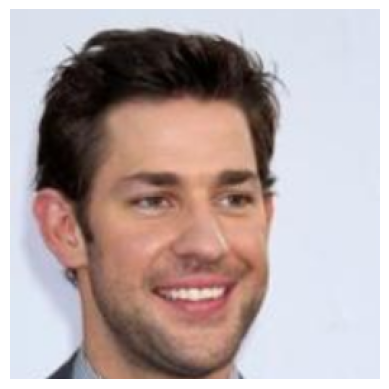

In [95]:
plot_image(dataset[0])

## 1. Rectangular masking

In [96]:
class CelebARectangleMaskedDataset(Dataset):
    def __init__(self, celeba_dataset: CelebADataset, image_size: int):
        self.celeba_dataset = dataset
        self.image_size = image_size

    def __len__(self):
      return len(self.celeba_dataset)

    def __getitem__(self, idx):
      """Returns a tuple of (image, masked_image)"""
      img = self.celeba_dataset[idx]
      mask = torch.zeros((3, self.image_size, self.image_size))
      mask = 1 - mask
      h = torch.randint(low=int(self.image_size / 8), high=int(self.image_size / 2) + 1, size=(1,))
      w = torch.randint(low=int(self.image_size / 8), high=int(self.image_size / 2) + 1, size=(1,))
      x0 = torch.randint(low=0, high=self.image_size - w, size=(1,))
      y0 = torch.randint(low=0, high=self.image_size - h, size=(1,))
      mask[:, y0:y0+h, x0:x0+w] = 0
      return img, mask

In [97]:
rectangle_masked_dataset = CelebARectangleMaskedDataset(dataset, 256)

In [98]:
img, mask = rectangle_masked_dataset[0]

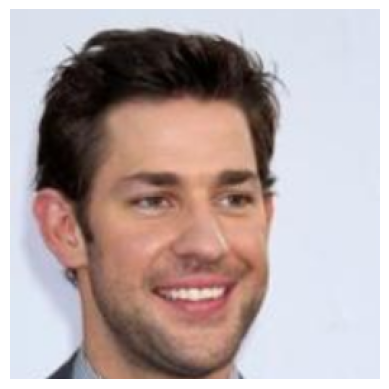

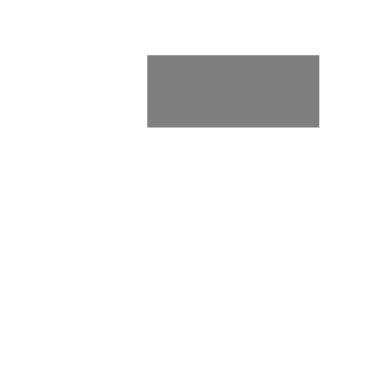

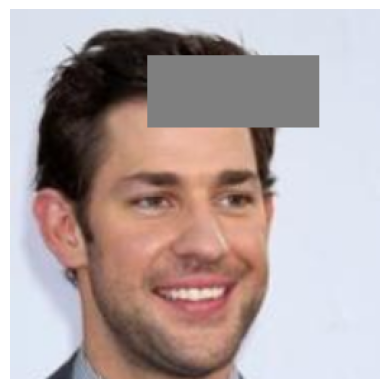

torch.Size([3, 256, 256])


In [99]:
plot_image(img)
plot_image(mask)
plot_image(img * mask)
print(mask.shape)

## 2. Perlin noise

In [100]:
import numpy as np
from scipy.ndimage import zoom

def perlin_noise_mask(B, H, W, threshold=0.5, scale=4):
    # Generate low-res noise
    low_h, low_w = H // scale, W // scale
    noise = np.random.randn(B, low_h, low_w)

    # Upsample to full resolution (gives you the smooth blobs)
    masks = np.zeros((B, H, W))
    for i in range(B):
        masks[i] = zoom(noise[i], scale, order=1)

    # Threshold to binary mask
    masks = (masks > threshold).astype(np.float32)

    return torch.from_numpy(masks)

masks = perlin_noise_mask(1, 256, 256, threshold=0.0001, scale=64)

torch.Size([1, 256, 256])

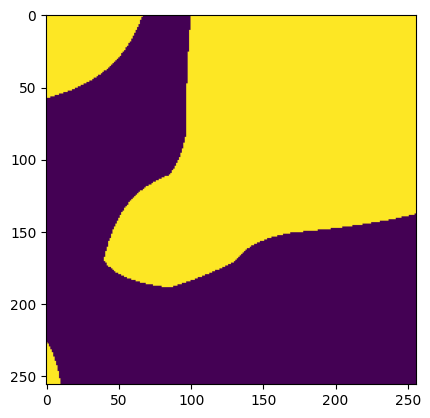

In [101]:
plt.imshow(masks[0])
masks.shape

In [102]:
class CelebAPerlinNoiseMaskedDataset(Dataset):
    def __init__(self,
                 celeba_dataset: CelebADataset,
                 image_size: int,
                 perlin_threshold: float,
                 perlin_scale: int
                 ):
        self.celeba_dataset = dataset
        self.image_size = image_size
        self.perlin_threshold = perlin_threshold
        self.perlin_scale = perlin_scale

    def __len__(self):
      return len(self.celeba_dataset)

    def _perlin_noise_mask(self):
      low_h, low_w = self.image_size // self.perlin_scale, self.image_size // self.perlin_scale
      noise = np.random.randn(1, low_h, low_w)

      mask = np.zeros((1, self.image_size, self.image_size))
      mask = zoom(noise, self.perlin_scale, order=1)

      mask = (mask > self.perlin_threshold).astype(np.float32)

      mask = mask[0].reshape((1, 256, 256))

      print(mask.shape)

      return torch.from_numpy(mask)

    def __getitem__(self, idx):
      """Returns a tuple of (image, masked_image)"""
      img = self.celeba_dataset[idx]
      mask = self._perlin_noise_mask()
      #mask = mask.repeat(3, 1, 1).reshape(3, self.image_size, self.image_size)
      #mask[:, :self.image_size, :self.image_size] = 1 - mask[:, :self.image_size, :self.image_size]
      return img, mask

(1, 256, 256)


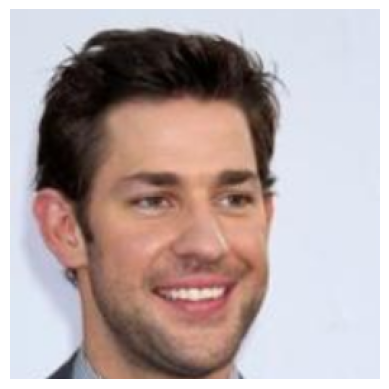

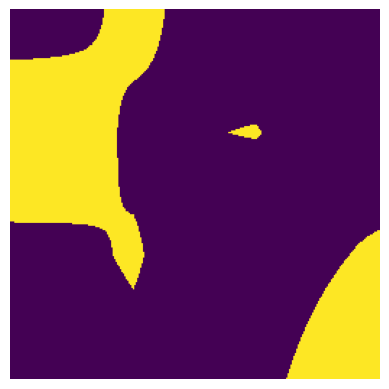

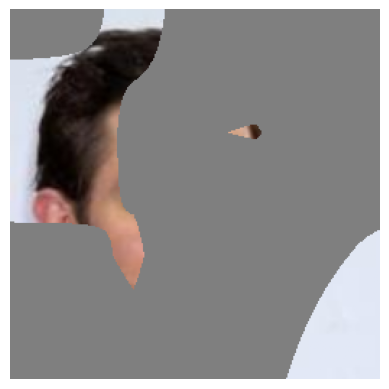

In [103]:
perlin_masked_dataset = CelebAPerlinNoiseMaskedDataset(dataset, 256, perlin_threshold=0.000005, perlin_scale=64)
img, mask = perlin_masked_dataset[0]
plot_image(img)
plot_image(mask)
plot_image(img * mask)

## 3. Feature masking

In [104]:
import mediapipe as mp
import cv2
from google.colab.patches import cv2_imshow

In [105]:
img = dataset[0]

img_processed = (img + 1) / 2 # [-1, 1] -> [0, 1]
img_processed = img_processed.permute(1, 2, 0) # (3, 256, 256) -> (256, 256, 3)

img_processed_np = (img_processed * 255).cpu().numpy().astype(np.uint8) # torch [0, 1] -> numpy [0, 255]

with mp.solutions.face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
) as face_mesh:
    results = face_mesh.process(img_processed_np)

In [106]:
if not results.multi_face_landmarks:
    raise RuntimeError("No faces detected")

face_landmarks = results.multi_face_landmarks[0].landmark
print("Got", len(face_landmarks), "landmarks")

Got 478 landmarks


In [107]:
type(results.multi_face_landmarks[0])

mediapipe.framework.formats.landmark_pb2.NormalizedLandmarkList

In [108]:
results

mediapipe.python.solution_base.SolutionOutputs

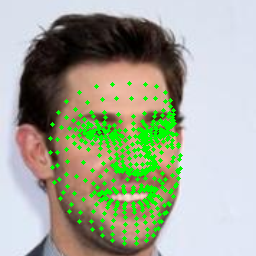

In [109]:
vis = img_processed_np.copy()

for lm in face_landmarks:
    cv2.circle(vis, (int(lm.x * 256), int(lm.y * 256)), 2, (0, 255, 0), -1)

cv2_imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))

In [110]:
FOREHEAD = [21, 54, 67, 10, 297, 284, 251, 9, 21]
LEFT_EYE = [463, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382, 362]
RIGHT_EYE = [33, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 7]
NOSE = [8, 343, 294, 2, 64, 114, 8]
MUSTACHE = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 358, 327, 326, 2, 97, 98, 129, 61]
LIPS = [ 61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 375, 321, 405, 314, 17, 84, 181, 91, 146, 61 ]
LEFT_CHEEK = [127, 230, 49, 207, 136, 58, 93, 127]
RIGHT_CHEEK = [356, 253, 279, 427, 365, 288, 401]
CHIN = [172, 84, 17, 314, 365, 377, 152, 148, 172]

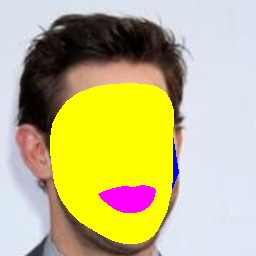

In [111]:
def draw_polygon_on_landmarks(image, landmarks, landmark_indices, color=(0, 255, 0)):
    points = []
    for idx in landmark_indices:
        lm = landmarks[idx]
        x, y = int(lm.x * 256), int(lm.y * 256)
        points.append([x, y])

    if points:
        points = np.array(points, np.int32).reshape((-1, 1, 2))
        cv2.fillPoly(image, [points], color)


vis_polygons = img_processed_np.copy()

# Draw and fill polygons for each defined landmark group
draw_polygon_on_landmarks(vis_polygons, face_landmarks, FOREHEAD, color=(255, 0, 0))
draw_polygon_on_landmarks(vis_polygons, face_landmarks, LEFT_EYE, color=(0, 255, 0))
draw_polygon_on_landmarks(vis_polygons, face_landmarks, RIGHT_EYE, color=(0, 255, 0))
draw_polygon_on_landmarks(vis_polygons, face_landmarks, NOSE, color=(0, 0, 255))
draw_polygon_on_landmarks(vis_polygons, face_landmarks, MUSTACHE, color=(255, 0, 0))
draw_polygon_on_landmarks(vis_polygons, face_landmarks, LIPS, color=(0, 0, 255))
draw_polygon_on_landmarks(vis_polygons, face_landmarks, LEFT_CHEEK, color=(0, 0, 255))
draw_polygon_on_landmarks(vis_polygons, face_landmarks, RIGHT_CHEEK, color=(0, 0, 255))
draw_polygon_on_landmarks(vis_polygons, face_landmarks, CHIN, color=(0, 0, 255))

cv2_imshow(cv2.cvtColor(vis_polygons, cv2.COLOR_BGR2RGB))

In [116]:
class CelebAFaceMaskedDataset(Dataset):
    FEATURES = {
        "FOREHEAD": [21, 54, 67, 10, 297, 284, 251, 9, 21],
        "LEFT_EYE": [463, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382, 362],
        "RIGHT_EYE": [33, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 7],
        "NOSE": [8, 343, 294, 2, 64, 114, 8],
        "MUSTACHE": [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 358, 327, 326, 2, 97, 98, 129, 61],
        "LIPS": [ 61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 375, 321, 405, 314, 17, 84, 181, 91, 146, 61 ],
        "LEFT_CHEEK": [127, 230, 49, 207, 136, 58, 93, 127],
        "RIGHT_CHEEK": [356, 253, 279, 427, 365, 288, 401],
        "CHIN": [172, 84, 17, 314, 365, 377, 152, 148, 172],
    }

    def __init__(self,
                 celeba_dataset: CelebADataset,
                 image_size: int
                 ):
        self.celeba_dataset = dataset
        self.image_size = image_size
        self.face_mesh = mp.solutions.face_mesh.FaceMesh(
            static_image_mode=True,
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5,
        )

    def __len__(self):
      return len(self.celeba_dataset)

    def draw_polygon_on_landmarks(self, image, landmarks, landmark_indices, color=(0, 0, 0), thickness=1):
      points = []
      for idx in landmark_indices:
          lm = landmarks[idx]
          x, y = int(lm.x * self.image_size), int(lm.y * self.image_size)
          points.append([x, y])

      if points:
          points = np.array(points, np.int32).reshape((-1, 1, 2))
          cv2.fillPoly(image, [points], color)

    def _feature_mask(self, img: torch.Tensor, feature: str):
      img_processed = (img + 1) / 2 # [-1, 1] -> [0, 1]
      img_processed = img_processed.permute(1, 2, 0) # (3, 256, 256) -> (256, 256, 3)

      img_processed_np = (img_processed * 255).cpu().numpy().astype(np.uint8) # torch [0, 1] -> numpy [0, 255]

      results = self.face_mesh.process(img_processed_np)

      if not results.multi_face_landmarks:
          raise RuntimeError("No faces detected")

      mask = np.zeros((self.image_size, self.image_size, 3))
      mask = 1 - mask

      draw_polygon_on_landmarks(mask, results.multi_face_landmarks[0].landmark, self.FEATURES[feature], color=(0, 0, 0))

      return torch.from_numpy(mask).permute(2, 0, 1)

    def __getitem__(self, idx):
      img = self.celeba_dataset[idx]

      feature_name = np.random.choice(list(self.FEATURES.keys()))
      mask = self._feature_mask(img, feature_name)

      return img, mask



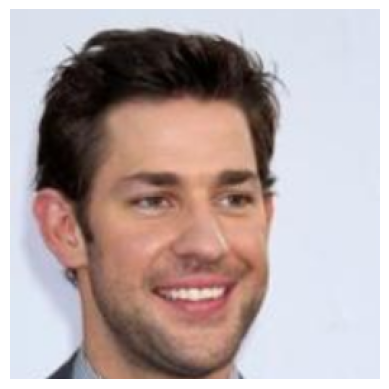

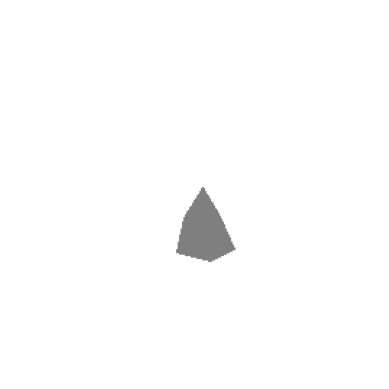

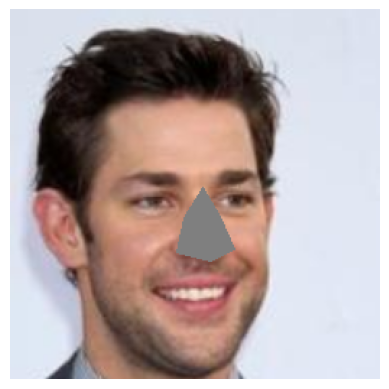

In [119]:
feature_masked_dataset = CelebAFaceMaskedDataset(dataset, 256)
img, mask = feature_masked_dataset[0]
plot_image(img)
plot_image(mask)
plot_image(img * mask)